Jan Půlpán

# Úvod

Tento Jupyter notebook obsahuje výsledky všech metod, které jsou v zadaní. Vlastní kód metod je uložen v samostatných souborech, z kterých se importuje do tohoto notebooku. 

# Načtení a vykreslení syrových dat.

Dvourozměrná data načtu z originálního textového souboru. Před jejich zpracováním a vykreslením je ještě normalizuji. To znamená, že zjistím střední hodnotu a tu posunu do bodu $(0,0)$. S takto normalizovanými daty se lépe pracuje v některých algoritmech, speciálně u lineárního klasifikátoru mohu volit počáteční iteraci $[0,0,0]$. Pokud je nutné klasifikovat data která normalizována nejsou, lze tuto transformaci (posunutí o -střední hodnota) snadno provést. Všechny výstupy jsou v této práci ve formě normalizovaných dat.

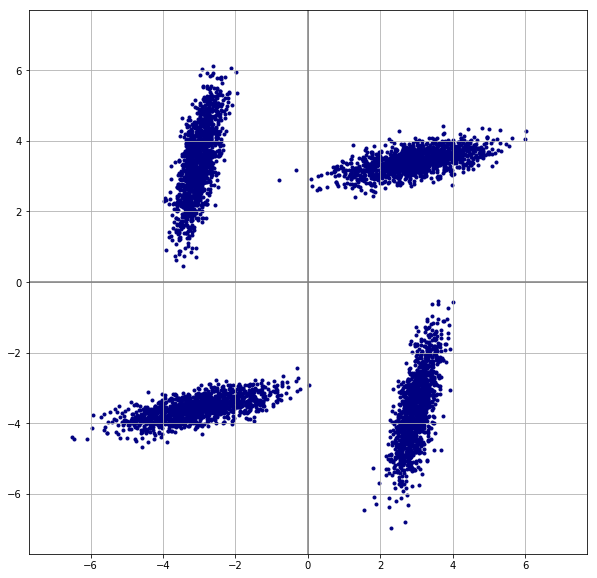

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

data = np.genfromtxt('data.txt', delimiter=' ')
data_len = len(data)

# normalizace dat
me = np.mean(data, axis=0)
data = data - me

plt_lim = int(np.ceil(np.amax([np.abs(np.amin(data)),np.abs(np.amax(data))])))
plt_lim += 0.1*plt_lim

plt.scatter(data[:,0],data[:,1], color='navy', marker='.')
plt.grid(True, which='both')
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.xlim(-plt_lim,plt_lim)
plt.ylim(-plt_lim,plt_lim)
plt.show()

# Určení počtu tříd

Z vykreslení všech dat jsou patrné 4 třídy. V následující části se to pokusím zjistit i algoritmicky.

## Metoda shlukovacích hladin

Metoda je velmi náročná na výpočetní čas. Následující kód má dobu běhu (na zadaných datech) přibližně 25min.

In [16]:
from shlukove_hladiny import shlukove_hladiny
cl_nb = shlukove_hladiny(data)
print('Počet tříd dat metodou shlukovacích hladin: %d' % cl_nb)

Počet tříd dat metodou shlukovacích hladin: 4


## Metoda řetězové mapy

Metoda řetězové mapy je sice výrazně rychlejší než metoda shlukovacích hladin, je ale velmi citlivá na výběr startovacího obrazu. Pokud použijeme náhodný výběr a ne nějaké vhodné kritérium tak je odhad počtu tříd opravdu jen přibližný. 

Pro demostraci je zde vykreslen graf distanční funkce jednohu běhu metody. Výsledný počet tříd je z grafu distanční funkce zrakem rozpoznatelný.

V praxi je lepší metodu pustit několikrát a jako výsledek pak brát průměrnou hodnotu odhadnutého počtu tříd. Díky menší časové náročnosti je možné toto udělat. Následující test obsahuje 10 běhů metody, pokaždé s jiným náhodným startovacím obrazem. Výsledný počet tříd je pak průměrná hodnota všech 10 běhů.

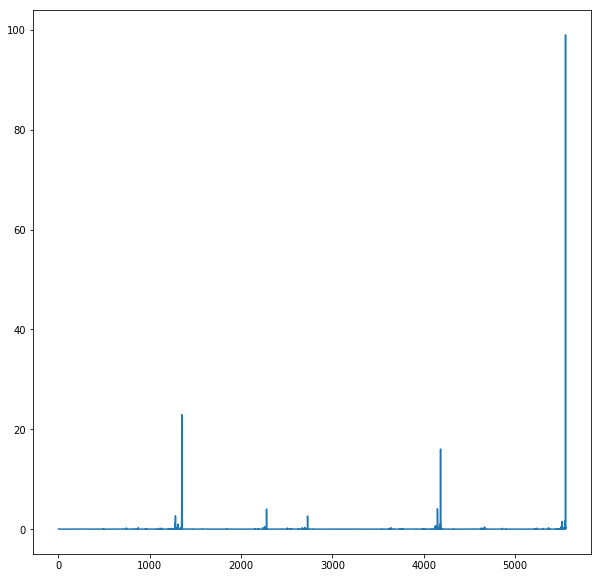

Počet tříd dat metodou řetězové mapy: 4


In [17]:
from retezova_mapa import retezova_mapa
cl_nb = retezova_mapa(data, True)

x = np.zeros(10)
rm = lambda t: retezova_mapa(data, False)
vfunc = np.vectorize(rm)
x = vfunc(x)
cl_nb = int(np.ceil(np.mean(x)))
print('Počet tříd dat metodou řetězové mapy: %d' % cl_nb)

## Metoda MAXIMIN

Metoda je citlivá na výběr startovacího obrazu, i když ne tak jako metoda řetězové mapy. Při jeho "špatném" výběru může vrátit neideální počet tříd. Je však velmi rychlá a proto volám funkci 100x a výsledný počet tříd získám jako průměr výsledků jednotlivých volání funkce. 

In [3]:
from maximin import maximin
x = np.zeros(100)
mm = lambda t: maximin(data)
vfunc = np.vectorize(mm)
x = vfunc(x)
cl_nb = int(np.ceil(np.mean(x)))
print('Počet tříd dat metodou maximin: %d' % cl_nb)

Počet tříd dat metodou maximin: 4


Všechny 3 metody vrátili stejný počet tříd, tedy 4. Metoda shlukovacích hladin je velmi náročná na výpočetní čas. U metody řetězové mapy je zase poměrně náročné rozhodnout o odhadovaném počtu tříd. Díky nenáročnosti metody MAXIMIN se zdá být tedy optimální použít tu, s tím že zprůměruji poměrně velké množství volání metody. 

# K-means 

## Přímé binární dělení

Data rozdělím do zadaného počtu tříd pomocí k-means metody s přímým dělením do tříd. Jako norma je použito Euklidovské kritérium. Počet tříd vím z metody MAXIMIN. Zastavovací podmínka je nastavena na $\epsilon = 10^{-3}$. Výsledek se pokusím ještě optimalizovat pomocí iterativní optimalizace. __Rozdělení do tříd závisí silně na výběru startovacích obrazů. Pro výběr do více více jak 2 tříd je složitější stanovit nějaký optimální výběr a tak jsou startovací obrazy vybrány náhodně. Pokud je ale (náhodně) vybrána sada optimálních startovacích obrazů, tak se výsledek neliší od binárního dělení (viz níže).__

Nejprve jsou uvedeny výsledky pro K-means s přímým dělením (výsledek je náhodný, může být i optimální). Iterativní optimalizace v tomto konkrétním případě moc nepomůže. __Vypsána je i hodnota kriteriální funkce, jak před, tak i po iterativní optimalizaci.__ 

Hodnota kriteriální funkce: 30103


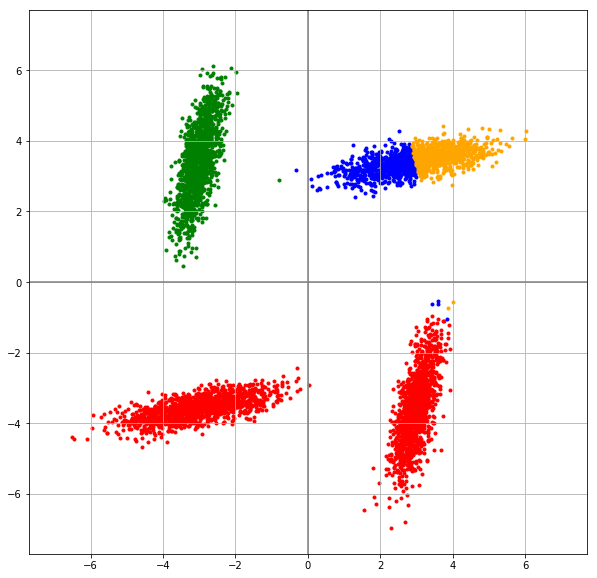

Hodnota kriteriální funkce po iterativní optimalizaci: 30103


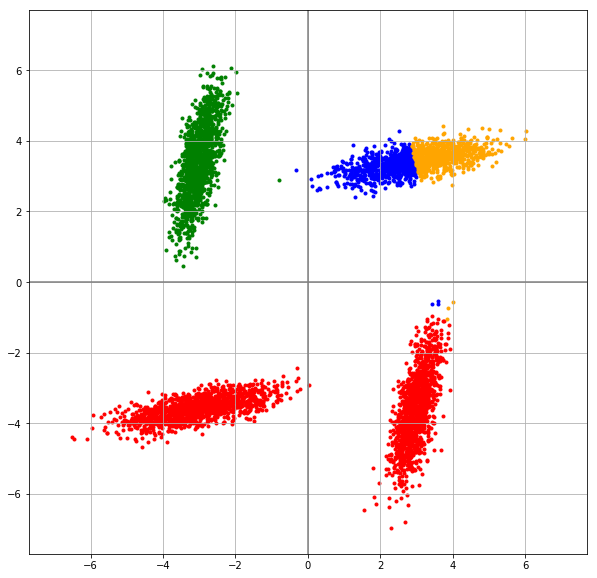

In [15]:
from kmeans import kmeans_direct,\
iterative_optim, kmeans_binary, plot_kmeans_result,\
get_crit_f

eps = 1.e-03 #nastavení zastavovací podmínky

data_classified, J_last = kmeans_direct(data, cl_nb, eps)
print('Hodnota kriteriální funkce: %d' % get_crit_f(data_classified))
plot_kmeans_result(data_classified, plt_lim)

data_classified= iterative_optim(data_classified, cl_nb)
print('Hodnota kriteriální funkce po iterativní optimalizaci: %d' % get_crit_f(data_classified))
plot_kmeans_result(data_classified, plt_lim)

## Nerovnoměrné binární dělení

I u nerovnoměrného binárního dělení není výsledek optimální. Stejná iterativní optimalizace tentokrát ale neoptimální výsledek "opraví", __což je vidět i z hodnoty kriteriální funkce před a po iterativní optimalizaci__. 

1. binární dělení, hodnota kriteriální funkce: 73983
2. binární dělení, hodnota kriteriální funkce: 3040
3. binární dělení, hodnota kriteriální funkce: 596
Hodnota kriteriální funkce celé sady: 38736


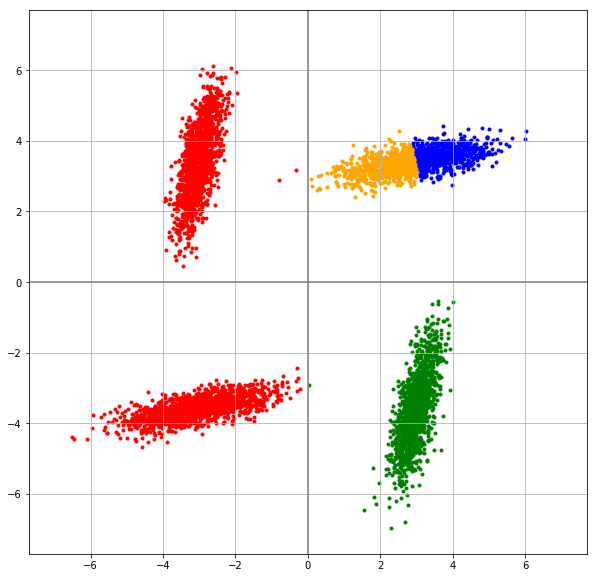

Hodnota kriteriální funkce po iterativní optimalizaci: 6162


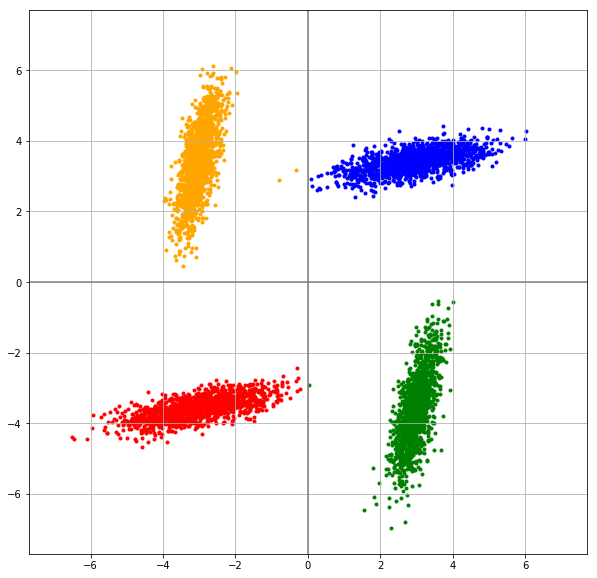

In [18]:
data_classified, J_crit = kmeans_binary(data, cl_nb, eps)
for i in range(1,len(J_crit)+1):
    print('%d. binární dělení, hodnota kriteriální funkce: %d' % (i,J_crit[i-1]))
print('Hodnota kriteriální funkce celé sady: %d' % get_crit_f(data_classified))
plot_kmeans_result(data_classified, plt_lim)

data_classified = iterative_optim(data_classified, cl_nb)
print('Hodnota kriteriální funkce po iterativní optimalizaci: %d' % get_crit_f(data_classified))
plot_kmeans_result(data_classified, plt_lim)

# Klasifikace s učitelem

Pomocí počtu tříd získaného metodou MAXIMIN a z něj vypočtených výsledků k-means, které využiji jako trénovací data, nyní natrénujeme několik různých typů klasifikátorů. 

## Bayesův klasifikátor

Pro každou třídu odhadnu parametry normálního rozdělení. Body v daném čtverci pak jen pomocí vzorce klasifikuji do tříd oddělených barvou (červená, modrá, zelená, oranžová). V obrázku jsou vynesena i původní data.

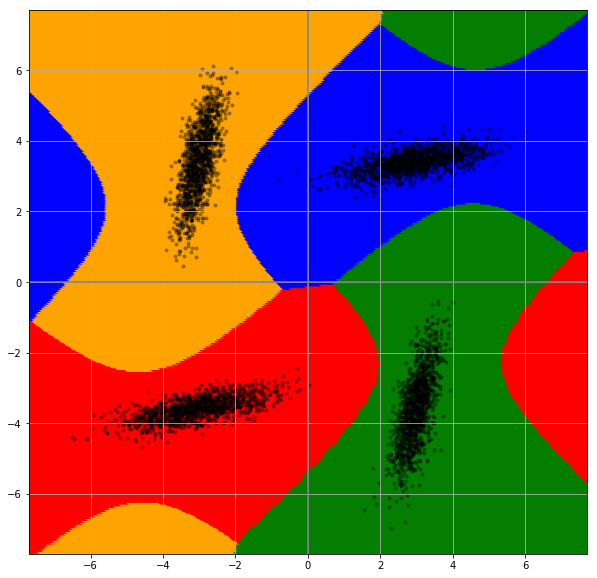

In [21]:
from bayes import bayes
from tools import plot_classifier_result

X,Y,Z = bayes(data_classified, plt_lim)
plot_classifier_result(data,X,Y,Z,plt_lim)

## Klasifikátor podle minimální vzdálenosti

Jednoduchý klasifikátor, kde stačí pro každou z tříd trénovacích dat vypočítat střední hodnotu $\mu$ a poté určit příslušnost do jednotlivé třídy pro jakýkoliv obraz jako nejkratší vzdáleností k množině středních hodnot $\mu_r$ pro $r \in \{1...$počet tříd$\}$.  

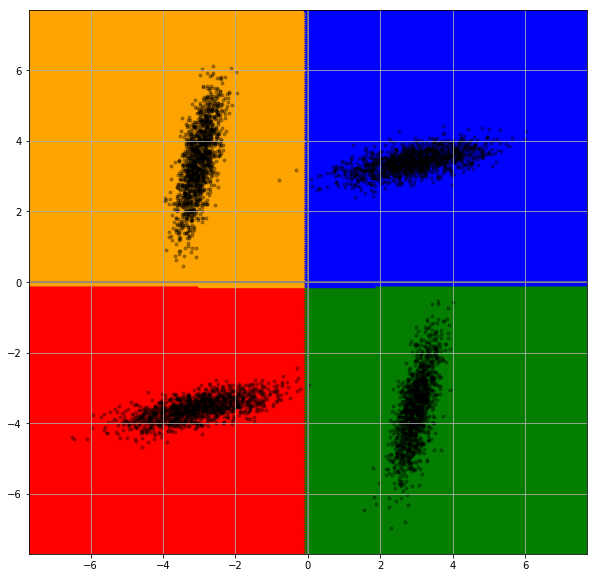

In [22]:
from min_dist import min_dist
from tools import plot_classifier_result

X,Y,Z = min_dist(data_classified, plt_lim)
plot_classifier_result(data,X,Y,Z,plt_lim)

## Klasifikátor podle nejbližšího souseda

Klasifikátor, jehož výsledky se nejvíce blíží Bayesovskému klasifikátoru. Parametr, který poddobnost zvětšuje je počet nejbližších sousedů. Nejprve proto zkusme použít jednoho nejbližšího souseda, poté i dva.

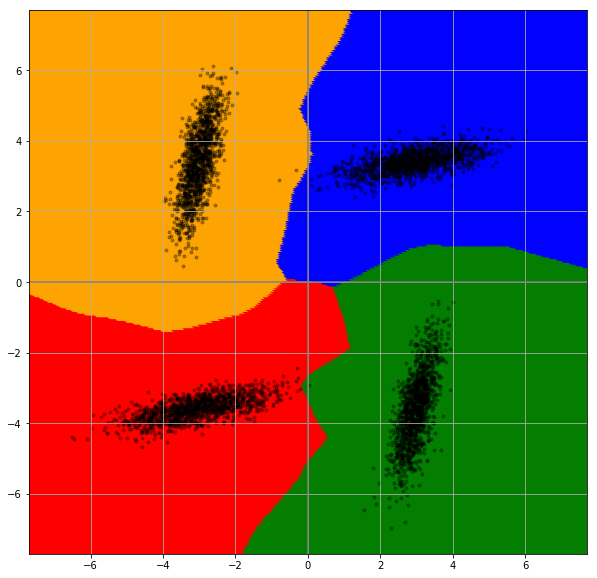

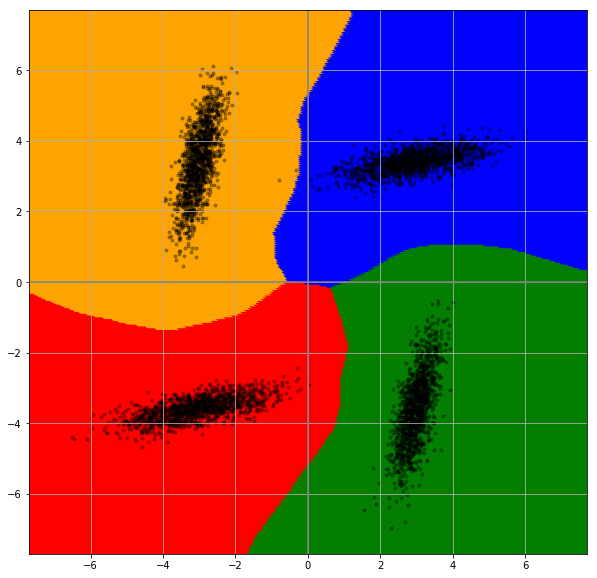

In [23]:
from kNN import kNN
from tools import plot_classifier_result

X,Y,Z = kNN(data_classified, 1, plt_lim)
plot_classifier_result(data,X,Y,Z,plt_lim)

X,Y,Z = kNN(data_classified, 2, plt_lim)
plot_classifier_result(data,X,Y,Z,plt_lim)

Zajímavé by mohlo být vyzkoušení většího počtu sousedů. Níže je výsledek pro 5 nejbližších sousedů.

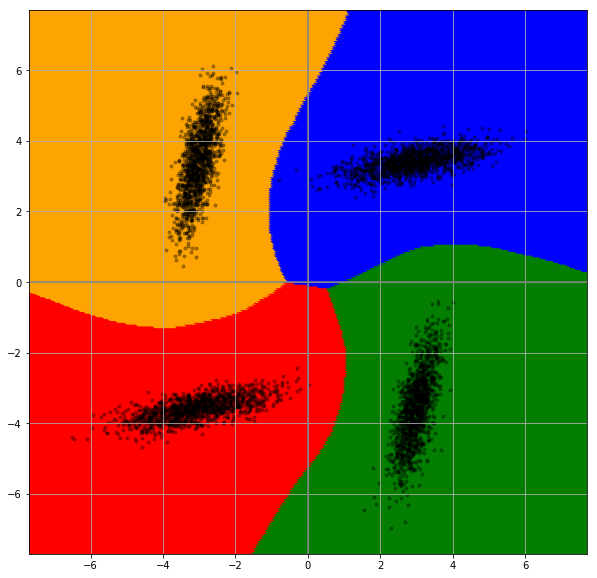

In [24]:
X,Y,Z = kNN(data_classified, 5, plt_lim)
plot_classifier_result(data,X,Y,Z,plt_lim)

## Klasifikátor s lineárními diskriminačními funkcemi

### Rosenblattův algoritmus

Aplikace základního Rosenbattova algoritmu s pro $c_k=1$ a $\delta=0$.

Žlutá plocha označuje oblast, v které nelze klasifikovat. Ta je dána průnikem lineárních klasifikátorů klasifikujících 2 různé třídy. V této žluté oblasti se nejde jednoznačně rozhodnout, do které třídy obraz patří.

Počet potřebných iterací v Rosenblattově algoritmu: 38


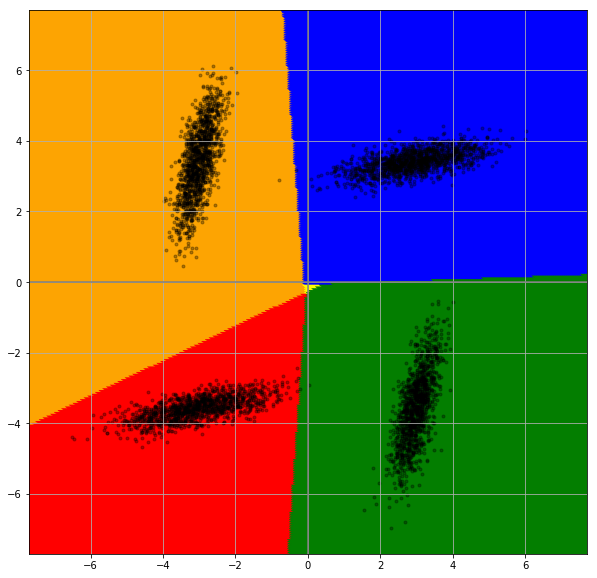

In [25]:
from linear import linear
from tools import plot_classifier_result

X,Y,Z,iter_cnt = linear(data_classified, 0, plt_lim)
print('Počet potřebných iterací v Rosenblattově algoritmu: %d' % iter_cnt)
plot_classifier_result(data,X,Y,Z,plt_lim)


### Metoda konstatních přírůstků

Pro $c_k = \frac{\beta}{\| x(k+1) \|^2}$ a $\delta=0$.

Počet potřebných iterací v metodě konstantních přírůstků: 18


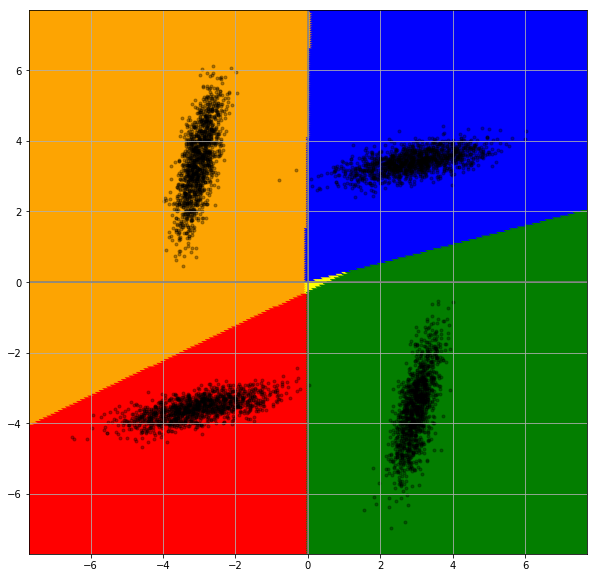

In [26]:
X,Y,Z,iter_cnt = linear(data_classified, 1, plt_lim)
print('Počet potřebných iterací v metodě konstantních přírůstků: %d' % iter_cnt)
plot_classifier_result(data,X,Y,Z,plt_lim)


### Upravená metoda konstatních přírůstků

Pro $c_k = \frac{\beta}{\| x(k+1) \|^2}$ a $\delta=0$. U jednotlivých obrazů probíhá úprava lineární klasifikační funkce tolikrát, dokud není klasifikace v pořádku.

Počet potřebných iterací v upravené metodě konstantních přírůstků: 18


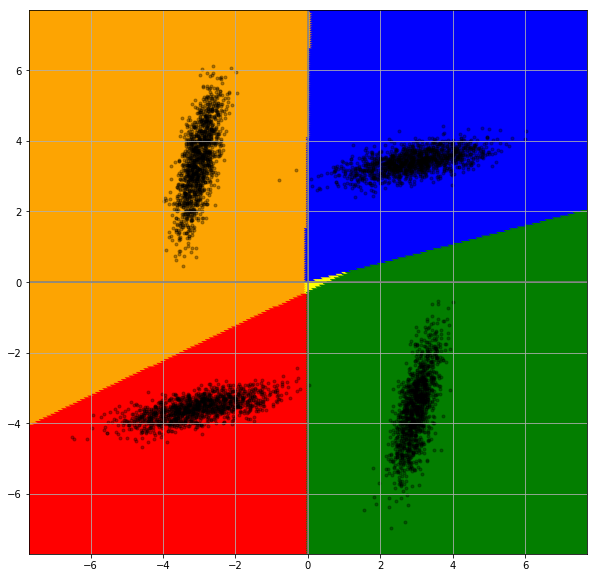

In [27]:
X,Y,Z,iter_cnt = linear(data_classified, 2, plt_lim)
print('Počet potřebných iterací v upravené metodě konstantních přírůstků: %d' % iter_cnt)
plot_classifier_result(data,X,Y,Z,plt_lim)


Díky normalizaci dat (vystředění okolo střední hodnoty $(0,0)$) a volbě počáteční iterace $[0,0,0]$ (místo přímky volím jen počátek, tedy bod) není vliv použité metody na počet iterací drastický. Pro zvolená data je dokonce počet iterací u metody konstatních přírůstků a upravené metody konstantních přírůstků shodný. 

Volba konstanty pro (upravenou) metodu konstantních přírůstků nemá na počet iterací žádný vliv. Pokud bych data nenormalizoval je situace poněkud jiná. Obě dvě možnosti, jak nenormalizace dat, tak i změnu konstanty jsem vyzkoušel. Zvolená varianta dává však nejlepší výsledky, tedy co nejmenší plochu, na které nelze klasifikovat.